# QAdaPrune for VQE

This notebook implements the QAdaPrune algorithm for running VQE problems with a UCCSD ansatz.

In [1]:
import pennylane as qml
import pennylane.numpy as qnp
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Qubits => ", qubits)
print("Hamiltonian: ", H)

Qubits =>  4
Hamiltonian:    (-0.24274501260969783) [Z3]
+ (-0.24274501260969777) [Z2]
+ (-0.04207255194718823) [I0]
+ (0.17771358229074435) [Z1]
+ (0.17771358229074438) [Z0]
+ (0.12293330449308097) [Z0 Z2]
+ (0.12293330449308097) [Z1 Z3]
+ (0.16768338855613268) [Z0 Z3]
+ (0.16768338855613268) [Z1 Z2]
+ (0.1705975927684062) [Z0 Z1]
+ (0.17627661394202926) [Z2 Z3]
+ (-0.04475008406305173) [Y0 Y1 X2 X3]
+ (-0.04475008406305173) [X0 X1 Y2 Y3]
+ (0.04475008406305173) [Y0 X1 X2 Y3]
+ (0.04475008406305173) [X0 Y1 Y2 X3]


In [3]:
electrons = 2
# orbitals = 7
hf_state = qml.qchem.hf_state(electrons, qubits)
hf_state

tensor([1, 1, 0, 0], requires_grad=True)

In [4]:
singles, doubles = qml.qchem.excitations(electrons, qubits)
s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

In [22]:
dev = qml.device('default.qubit', wires=qubits)
@qml.qnode(dev, interface='autograd', diff_method='parameter-shift')
def ckt(weights):
    qml.UCCSD(weights, 
              wires=list(range(qubits)), 
              s_wires=s_wires,
              d_wires=d_wires, init_state=hf_state)
    return qml.expval(H)

In [30]:
weights = qnp.random.normal(0, np.pi, 3)

In [24]:
print(qml.draw(ckt, expansion_strategy='device')(weights))

0: ─╭BasisState(M0)──H─────────╭●───────────────────────╭●──────────H──────────RX(-1.57)─╭●──────
1: ─├BasisState(M0)──H─────────╰X─╭●─────────────────╭●─╰X──────────H──────────H─────────╰X─╭●───
2: ─├BasisState(M0)──RX(-1.57)────╰X─╭●───────────╭●─╰X──RX(1.57)───RX(-1.57)───────────────╰X─╭●
3: ─╰BasisState(M0)──H───────────────╰X──RZ(0.37)─╰X──H──RX(-1.57)─────────────────────────────╰X

─────────────────────────╭●──────────RX(1.57)───H─────────╭●──────────────────────────────╭●────────
───────────────╭●────────╰X──────────H──────────RX(-1.57)─╰X─╭●─────────────────╭●────────╰X────────
────────────╭●─╰X─────────RX(1.57)───RX(-1.57)───────────────╰X─╭●───────────╭●─╰X─────────RX(1.57)─
───RZ(0.37)─╰X──RX(1.57)──RX(-1.57)─────────────────────────────╰X──RZ(0.37)─╰X──RX(1.57)──RX(-1.57)

───H─────────H─╭●──────────────────────────────╭●──H──RX(-1.57)─╭●────────────────────────╭●
───RX(1.57)──H─╰X─╭●─────────────────╭●────────╰X──H──H─────────╰X─╭●──────────────────╭●─╰X
───H────────────

In [23]:
qml.specs(ckt)(weights)

{'gate_sizes': defaultdict(int, {4: 2, 3: 2}),
 'gate_types': defaultdict(int,
             {'BasisState': 1,
              'FermionicDoubleExcitation': 1,
              'FermionicSingleExcitation': 2}),
 'num_operations': 4,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 4,
 'depth': 4,
 'num_trainable_params': 3,
 'num_device_wires': 4,
 'device_name': 'default.qubit',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'autograd',
 'diff_method': 'parameter-shift',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 12}

In [36]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

for g in grad_hist:
    print("Gradient: ", g)
    g_up = g - g * softmax(g)
    print("Softmax weights: ", softmax(g))
    print("After update: ", g_up)

Gradient:  [ 0.17560253 -0.14987952  0.15880275]
Softmax weights:  [0.36961476 0.26692807 0.36345718]
After update:  [ 0.11069724 -0.10987247  0.10108475]
Gradient:  [ 0.12322193 -0.14941906  0.14874242]
Softmax weights:  [0.35878108 0.27316374 0.36805518]
After update:  [ 0.07901223 -0.10860319  0.093997  ]
Gradient:  [ 0.08064547 -0.14845407  0.13361699]
Softmax weights:  [0.35092041 0.27906924 0.37001035]
After update:  [ 0.05234533 -0.10702511  0.08417732]
Gradient:  [ 0.04731408 -0.14719226  0.11512829]
Softmax weights:  [0.34561327 0.284523   0.36986373]
After update:  [ 0.0309617  -0.10531268  0.07254651]
Gradient:  [ 0.02183029 -0.14592417  0.09448001]
Softmax weights:  [0.34235845 0.2894851  0.36815646]
After update:  [ 0.0143565  -0.1036813   0.05969658]
Gradient:  [ 0.00264735 -0.14509988  0.07255114]
Softmax weights:  [0.34070922 0.29391251 0.36537827]
After update:  [ 0.00174537 -0.10245321  0.04604253]
Gradient:  [-0.01161383 -0.14529786  0.04997056]
Softmax weights:  [0.

In [47]:
# if I wasn't hard pressed for time this wouldn't happen...
def optimize_and_prune(opt, ckt, weights, steps=30, win_sz=5, tol=0.001):
    tweights = weights.copy()
    tweights.requires_grad = True
    energy_hist = []
    
    gfn = qml.grad(ckt, argnum=0)
    tau = qnp.ones(tweights.size, requires_grad=False) * 1/tweights.size
    prev_idx, idx = None, None
    gbuffer = np.zeros(tweights.size)
    igrad = gfn(tweights)
    gbuffer = np.abs(gbuffer - igrad)
    for i in range(steps):
        tweights, energy = opt.step_and_cost(ckt, tweights)
        if idx is not None:
            tweights[idx] = 0
        energy_hist.append(energy)
        grad = gfn(tweights)
        tau = tau - tau * softmax(grad)
        gbuffer = np.abs(gbuffer - grad)
        if i != 0 and i % win_sz == 0:
            idx = build_saliency(gbuffer, tau)
            if not idx and prev_idx:
                idx = prev_idx
            print(f"Dropping {idx} for threshold {tau}")
            tweights[idx] = 0
            prev_idx = idx
        if i % 2 == 0:
            print(f"Step: {i}, Energy: {energy} Ha")
        
        # conv = np.abs(energy_hist[-1] - energy)
        # if conv <= tol:
        #     break
    return energy_hist

In [41]:
def build_saliency(grad_buffer, thresh_vec):
    gbuf = grad_buffer.flatten()
    prune_idx = []
    for i, g in enumerate(gbuf):
        if g < thresh_vec[i]:
            prune_idx.append(i)
    return prune_idx

In [50]:
iwts = qnp.random.normal(0, np.pi, 3, requires_grad=False)
opt_new = qml.GradientDescentOptimizer(stepsize=0.5)

In [51]:
energy_hist_prune = optimize_and_prune(opt_new, ckt, iwts)

Step: 0, Energy: -0.6861072929620893 Ha
Step: 2, Energy: -0.9916299945609333 Ha
Step: 4, Energy: -1.0945635590038343 Ha
Dropping [0, 2] for threshold [0.03975597 0.02532095 0.02448822]
Step: 6, Energy: -1.1010620197023109 Ha
Step: 8, Energy: -1.110726119466513 Ha
Dropping [0] for threshold [0.00458601 0.00265335 0.00453955]
Step: 10, Energy: -1.1146800353933717 Ha
Step: 12, Energy: -1.128835175823976 Ha
Step: 14, Energy: -1.135083340543473 Ha
Dropping [0] for threshold [0.00058379 0.00032746 0.00065852]
Step: 16, Energy: -1.1359529562553068 Ha
Step: 18, Energy: -1.136119847667498 Ha
Dropping [0] for threshold [7.67758060e-05 4.26754474e-05 8.77410163e-05]
Step: 20, Energy: -1.1361653084842642 Ha
Step: 22, Energy: -1.1361804779882578 Ha
Step: 24, Energy: -1.1361859458897214 Ha
Dropping [0] for threshold [1.01118499e-05 5.60574479e-06 1.15816841e-05]
Step: 26, Energy: -1.1361879651375786 Ha
Step: 28, Energy: -1.1361887161550972 Ha


In [53]:
opt = qml.GradientDescentOptimizer(stepsize=0.5)
# params = qnp.zeros(len(singles) + len(doubles), requires_grad=True)
energy_hist = []
grad_hist = []
weights = iwts.copy()
weights.requires_grad = True
for i in range(30):
    weights, energy = opt.step_and_cost(ckt, weights)
    energy_hist.append(energy)
    if i % 2 == 0:
        print(f"Step -> {i}, Energy: {energy} Ha")
    

Step -> 0, Energy: -0.6861072929620893 Ha
Step -> 2, Energy: -0.9916299945609333 Ha
Step -> 4, Energy: -1.0945635590038343 Ha
Step -> 6, Energy: -1.1203712415589118 Ha
Step -> 8, Energy: -1.1285547029474723 Ha
Step -> 10, Energy: -1.132092249935285 Ha
Step -> 12, Energy: -1.1339016528803993 Ha
Step -> 14, Energy: -1.1348926944765931 Ha
Step -> 16, Energy: -1.1354500658921975 Ha
Step -> 18, Energy: -1.135766822558795 Ha
Step -> 20, Energy: -1.1359475938314982 Ha
Step -> 22, Energy: -1.1360509359134219 Ha
Step -> 24, Energy: -1.136110055562595 Ha
Step -> 26, Energy: -1.1361438865108555 Ha
Step -> 28, Energy: -1.1361632485092963 Ha


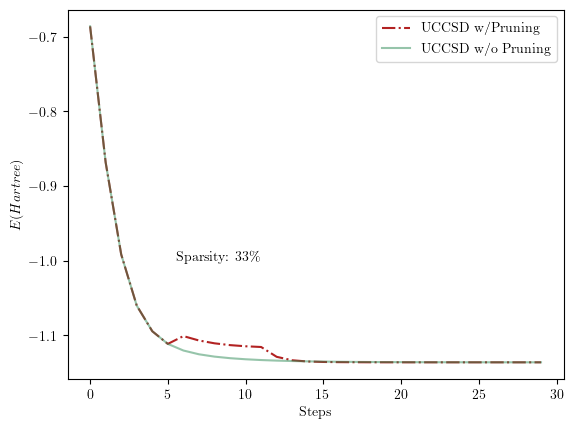

In [81]:
plt.text(5.5, -1.0, 'Sparsity: 33\%')
plt.plot(np.arange(len(energy_hist_prune)), energy_hist_prune, '-.', c='firebrick', label='UCCSD w/Pruning')
plt.plot(np.arange(len(energy_hist)), energy_hist, c='seagreen', alpha=0.5, label='UCCSD w/o Pruning')
plt.legend()

plt.xlabel('Steps')
plt.ylabel(r'$E(Hartree)$')
plt.savefig('vqe_uccsd_param_pruning.pdf', dpi=300, bbox_inches='tight')